In [ ]:
# from rdkit import Chem
# from deepchem.feat.smiles_tokenizer import BasicSmilesTokenizer

# smiles = "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O"
# tokenizer = BasicSmilesTokenizer()
# tokens = tokenizer.tokenize(smiles)
# print("Tokenized SMILES:", tokens)

In [13]:
from sklearn.metrics import (
    accuracy_score,
    log_loss,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    confusion_matrix,
)

from pprint import pprint

In [1]:
from transformers import BertTokenizer, BertModel

# Use a pre-trained tokenizer and model (e.g., ChemBERTa)
tokenizer = BertTokenizer.from_pretrained(
    "seyonec/SMILES_tokenized_PubChem_shard00_160k"
)
model = BertModel.from_pretrained("seyonec/SMILES_tokenized_PubChem_shard00_160k")

# Tokenize SMILES string
inputs = tokenizer("CC(C)CC1=CC=C(C=C1)C(C)C(=O)O", return_tensors="pt")
outputs = model(**inputs)

# Get the embeddings
smiles_embedding = outputs.last_hidden_state
print("SMILES Embedding Shape:", smiles_embedding.shape)
# SMILES Embedding Shape: torch.Size([1, 26, 768])

c:\Users\predator\anaconda3\envs\dili-3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertModel were not initialized from the model checkpoint at seyonec/SMILES_tokenized_PubChem_shard00_160k and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight'

SMILES Embedding Shape: torch.Size([1, 26, 768])


In [2]:
smiles_embedding_np = smiles_embedding.detach().cpu().numpy()  # Convert to NumPy array
smiles_embedding_np

array([[[-0.9456742 , -0.07845324, -0.11232515, ...,  0.46744674,
         -1.0139995 ,  1.4810507 ],
        [-0.22752549,  0.27403775,  0.34091073, ...,  2.8171782 ,
         -0.77884924,  0.5986685 ],
        [-0.7380672 ,  2.166621  ,  0.5120643 , ...,  1.1974899 ,
          0.12713408,  0.7970753 ],
        ...,
        [-0.8024343 ,  0.35517752, -0.14155419, ...,  1.8256483 ,
         -0.20838098, -0.7751108 ],
        [-0.54031295,  1.1234654 ,  0.18795578, ...,  1.6086391 ,
         -0.01333004,  0.6416502 ],
        [-0.02481757,  0.75252944, -0.45203415, ...,  1.6059102 ,
         -0.3453524 ,  0.4650128 ]]], dtype=float32)

In [3]:
smiles_embedding_np.shape

(1, 26, 768)

# Data preparation

In [2]:
import pandas as pd
import numpy as np
import joblib

In [5]:
# Load pd_train
pd_train = pd.read_parquet("data/training_class_x20.parquet")
pd_train["label"] = pd_train["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_train.shape)
pd_train.head()

(24759, 16096)


,Liver,Smiles,Name,FP1,FP2,FP3,FP4,FP5,FP6,FP7,...,APC2D10_I_B,APC2D10_I_Si,APC2D10_I_X,APC2D10_B_B,APC2D10_B_Si,APC2D10_B_X,APC2D10_Si_Si,APC2D10_Si_X,APC2D10_X_X,label
0,Hepatotoxicity,S=C=Nc1c2c(ccc1)cccc2,AUTOGEN_Training_Group_PaDel_index_x20_7,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,Hepatotoxicity,c1cc2c(cc1)c(N=C=S)ccc2,AUTOGEN_Training_Group_PaDel_index_x20_1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,Hepatotoxicity,c1c2c(ccc1)cccc2N=C=S,AUTOGEN_Training_Group_PaDel_index_x20_8,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,Hepatotoxicity,c12ccccc1c(N=C=S)ccc2,AUTOGEN_Training_Group_PaDel_index_x20_9,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,Hepatotoxicity,c1ccc2c(c1)cccc2N=C=S,AUTOGEN_Training_Group_PaDel_index_x20_5,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [6]:
pd_train["label"].value_counts()

label
1    13671
0    11088
Name: count, dtype: int64

In [7]:
# Load pd_test
pd_test = pd.read_parquet("data/testing_class_x20.parquet")
pd_test["label"] = pd_test["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_test.shape)
pd_test.head()

(286, 16096)


,Smiles,Liver,Name,FP1,FP2,FP3,FP4,FP5,FP6,FP7,...,APC2D10_I_B,APC2D10_I_Si,APC2D10_I_X,APC2D10_B_B,APC2D10_B_Si,APC2D10_B_X,APC2D10_Si_Si,APC2D10_Si_X,APC2D10_X_X,label
0,C[C@@H](C(=O)N[C@@H](C)C(=O)NC1[C@H]2[C@@H]1CN...,Hepatotoxicity,AUTOGEN_Testing_Group_PaDel_index_x20_2,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,C=CCOC1=C(C=C(C=C1)CC(=O)O)Cl,Hepatotoxicity,AUTOGEN_Testing_Group_PaDel_index_x20_3,0,1,0,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,CCCN(CCC)C(=O)CC1=C(N=C2N1C=C(C=C2)Cl)C3=CC=C(...,Hepatotoxicity,AUTOGEN_Testing_Group_PaDel_index_x20_1,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,C1CC2=CC=CC=C2C(C3=CC=CC=C31)NCCCCCCC(=O)O,Hepatotoxicity,AUTOGEN_Testing_Group_PaDel_index_x20_4,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,C1=CC=C(C=C1)CN2C3=CC=CC=C3C(=N2)OCC(=O)O,Hepatotoxicity,AUTOGEN_Testing_Group_PaDel_index_x20_5,0,0,1,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [8]:
pd_test["label"].value_counts()

label
1    221
0     65
Name: count, dtype: int64

In [9]:
# Tokenize and embed each SMILES string
def embed_smiles(smiles):
    inputs = tokenizer(smiles, return_tensors="pt", max_length=514, truncation=True)
    outputs = model(**inputs)
    # Use mean pooling to create a fixed-size embedding
    embedding = outputs.last_hidden_state.mean(dim=1)
    return embedding.detach().cpu().numpy()


# Apply embedding to each SMILES string
pd_train["Embeddings"] = pd_train["Smiles"].apply(embed_smiles)

# Save the embeddings
joblib.dump(pd_train, "data_smiles/Training_Group_embeddings_x20.pkl")

['data_smiles/Training_Group_embeddings_x20.pkl']

In [10]:
pd_test["Embeddings"] = pd_test["Smiles"].apply(embed_smiles)
joblib.dump(pd_test, "data_smiles/Testing_Group_embeddings_x20.pkl")

['data_smiles/Testing_Group_embeddings_x20.pkl']

In [3]:
# load the embeddings
pd_train = joblib.load("data_smiles/Training_Group_embeddings_x20.pkl")
pd_test = joblib.load("data_smiles/Testing_Group_embeddings_x20.pkl")

In [4]:
# Prepare features and labels for the split
X_train = np.vstack(pd_train["Embeddings"].values)  # Stack embeddings into a 2D array
y_train = pd_train["label"].values

print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)

X_train Shape: (24759, 768)
y_train Shape: (24759,)


In [5]:
X_test = np.vstack(pd_test["Embeddings"].values)  # Stack embeddings into a 2D array
y_test = pd_test["label"].values

print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)

X_test Shape: (286, 768)
y_test Shape: (286,)


# Model training

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def compute_loss(y_hat, y):
    y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)

    return (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()


def predict(X, theta):
    dot_product = np.dot(X, theta)
    y_hat = sigmoid(dot_product)

    return y_hat


def compute_gradient(X, y, y_hat):
    return np.dot(X.T, (y_hat - y)) / y.size


def update_theta(theta, gradient, lr):
    return theta - lr * gradient


def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta).round()
    acc = (y_hat == y).mean()

    return acc

In [24]:
# lr = 0.01
# epochs = 200
# batch_size = 128

# lr = 0.04593015794979118
# epochs = 180
# batch_size = 256

random_state = 2

lr = 0.07157358459955648
epochs = 101
batch_size = 256

np.random.seed(random_state)
theta = np.random.uniform(size=X_train.shape[1])

In [25]:
train_accs = []
train_losses = []
test_accs = []
test_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    test_batch_losses = []
    test_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i : i + batch_size]
        y_i = y_train[i : i + batch_size]

        y_hat = predict(X_i, theta)

        train_loss = compute_loss(y_hat, y_i)

        gradient = compute_gradient(X_i, y_i, y_hat)

        theta = update_theta(theta, gradient, lr)

        train_batch_losses.append(train_loss)

        train_acc = compute_accuracy(X_train, y_train, theta)
        train_batch_accs.append(train_acc)

        y_test_hat = predict(X_test, theta)
        test_loss = compute_loss(y_test_hat, y_test)
        test_batch_losses.append(test_loss)

        test_acc = compute_accuracy(X_test, y_test, theta)
        test_batch_accs.append(test_acc)

    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    test_batch_loss = sum(test_batch_losses) / len(test_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    test_batch_acc = sum(test_batch_accs) / len(test_batch_accs)

    train_losses.append(train_batch_loss)
    test_losses.append(test_batch_loss)
    train_accs.append(train_batch_acc)
    test_accs.append(test_batch_acc)

    print(
        f"\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss:.3f}\ttestidation loss: {test_batch_loss:.3f}"
    )


EPOCH 1:	Training loss: 3.592	testidation loss: 3.329

EPOCH 2:	Training loss: 3.534	testidation loss: 3.266

EPOCH 3:	Training loss: 3.579	testidation loss: 3.226

EPOCH 4:	Training loss: 3.504	testidation loss: 3.165

EPOCH 5:	Training loss: 3.488	testidation loss: 3.099

EPOCH 6:	Training loss: 3.049	testidation loss: 2.877

EPOCH 7:	Training loss: 3.567	testidation loss: 3.035

EPOCH 8:	Training loss: 3.450	testidation loss: 3.044

EPOCH 9:	Training loss: 3.398	testidation loss: 2.956

EPOCH 10:	Training loss: 3.386	testidation loss: 2.923

EPOCH 11:	Training loss: 3.383	testidation loss: 2.803

EPOCH 12:	Training loss: 3.355	testidation loss: 2.855

EPOCH 13:	Training loss: 3.248	testidation loss: 2.824

EPOCH 14:	Training loss: 3.185	testidation loss: 2.609

EPOCH 15:	Training loss: 3.441	testidation loss: 2.792

EPOCH 16:	Training loss: 3.412	testidation loss: 2.759

EPOCH 17:	Training loss: 3.318	testidation loss: 2.646

EPOCH 18:	Training loss: 3.061	testidation loss: 2.633



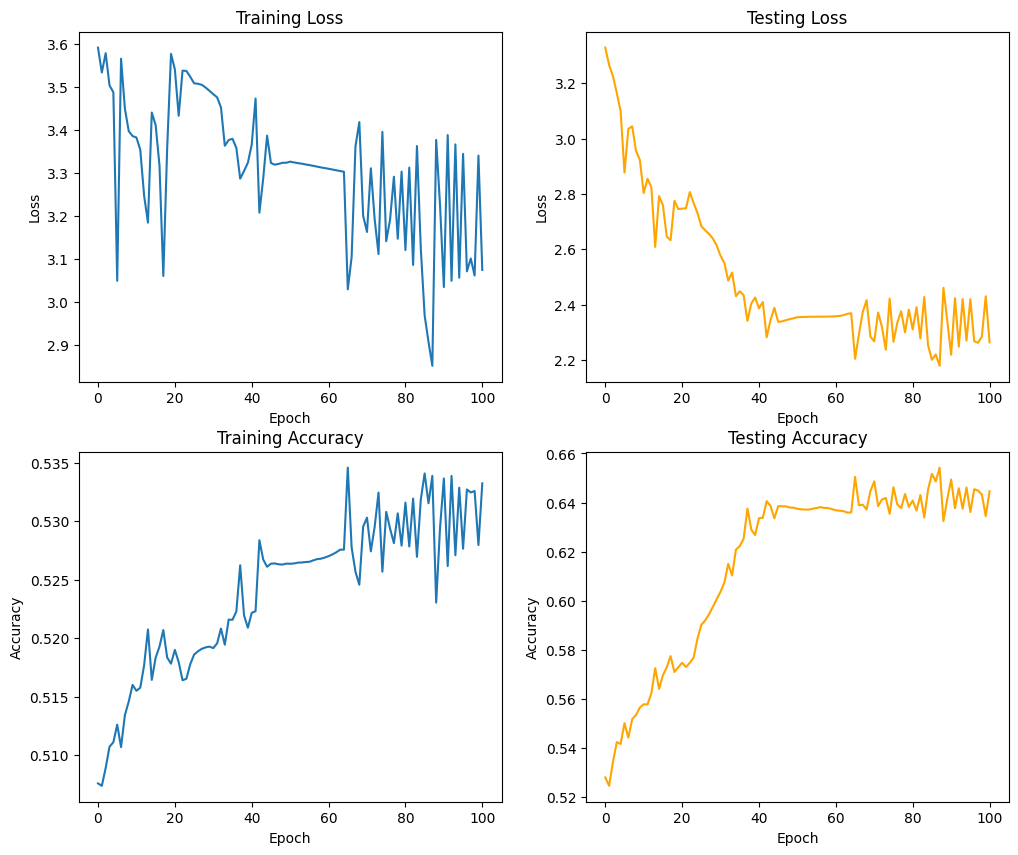

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel="Epoch", ylabel="Loss")
ax[0, 0].set_title("Training Loss")

ax[0, 1].plot(test_losses, "orange")
ax[0, 1].set(xlabel="Epoch", ylabel="Loss")
ax[0, 1].set_title("Testing Loss")

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 0].set_title("Training Accuracy")

ax[1, 1].plot(test_accs, "orange")
ax[1, 1].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 1].set_title("Testing Accuracy")

plt.show()

In [27]:
y_pred_proba = predict(X_test, theta)
y_true = y_test
auc = roc_auc_score(y_true, y_pred_proba)

# Initialize variables to store the best threshold and performance metrics
best_threshold = 0.5
best_metrics = {
    "accuracy": 0,
    "precision": 0,
    "recall": 0,
    "sensitivity": 0,
    "specificity": 0,
    "f1": 0,
}

# Iterate over possible thresholds
for threshold in np.arange(0.0, 1.0, 0.01):
    # Binarize predictions based on the current threshold
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calculate precision, recall, accuracy, sensitivity, and specificity
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)  # Same as sensitivity for positive class
    accuracy = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = f1_score(y_true, y_pred)

    # Update the best threshold if Youden's J is higher than previous best
    if f1 > best_metrics["f1"]:
        best_threshold = threshold
        best_metrics = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "sensitivity": sensitivity,
            "specificity": specificity,
            "f1": f1,
        }

# Append results to list
result = {
    "Best Threshold": best_threshold,
    "AUC": auc,
    **best_metrics,
}

pprint(result)

{'AUC': 0.6780020884093283,
 'Best Threshold': 0.0,
 'accuracy': 0.7727272727272727,
 'f1': 0.8717948717948718,
 'precision': 0.7727272727272727,
 'recall': 1.0,
 'sensitivity': 1.0,
 'specificity': 0.0}


# Model optuna

In [20]:
import optuna

In [21]:
# Optuna Objective function to optimize AUC
def objective(trial):
    # Define hyperparameters to tune
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    epochs = trial.suggest_int("epochs", 50, 500)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])

    # Initialize parameters
    theta = np.random.uniform(size=X_train.shape[1])
    train_losses = []
    test_losses = []
    test_aucs = []

    # Training loop
    for epoch in range(epochs):
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i : i + batch_size]
            y_batch = y_train[i : i + batch_size]

            # Forward pass and loss
            y_hat = predict(X_batch, theta)
            train_loss = compute_loss(y_hat, y_batch)
            gradient = compute_gradient(X_batch, y_batch, y_hat)
            theta = update_theta(theta, gradient, lr)

        # Calculate AUC on test data
        y_test_hat = predict(X_test, theta)
        test_auc = roc_auc_score(y_test, y_test_hat)
        test_aucs.append(test_auc)

        # Stop early if AUC is satisfactory
        trial.report(test_auc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return max(test_aucs)

In [22]:
# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2024-11-13 20:44:41,812] A new study created in memory with name: no-name-b75461b9-d0cf-482e-993d-9743f08aae52
C:\Users\predator\AppData\Local\Temp\ipykernel_17184\2620807037.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
[I 2024-11-13 20:45:31,137] Trial 0 finished with value: 0.7068917507831535 and parameters: {'lr': 0.013079253305147224, 'epochs': 440, 'batch_size': 256}. Best is trial 0 with value: 0.7068917507831535.
C:\Users\predator\AppData\Local\Temp\ipykernel_17184\2620807037.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
[I 2024-11-13 20:45:52,526] Tria

In [ ]:
# Display best trial
print("Best trial:")
trial = study.best_trial
print(f"  AUC Score: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Model tuning

In [24]:
from tpot import TPOTClassifier

# Set up TPOT with basic configuration
tpot = TPOTClassifier(
    generations=5,
    population_size=20,
    verbosity=2,
    scoring="roc_auc",  # AUC
    random_state=42,
    n_jobs=6,  # Use 4 cores
)

# Fit the model
tpot.fit(X_train, y_train)

                                                                                
Generation 1 - Current best internal CV score: 0.6285661899200286
                                                                             
Generation 2 - Current best internal CV score: 0.6285661899200286
                                                                             
Generation 3 - Current best internal CV score: 0.6285661899200286
                                                                             
Generation 4 - Current best internal CV score: 0.6304239121477188
                                                           
Generation 5 - Current best internal CV score: 0.6304239121477188
                                                           
Best pipeline: XGBClassifier(input_matrix, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=100, n_jobs=1, subsample=0.35000000000000003, verbosity=0)


TPOTClassifier(generations=5, n_jobs=6, population_size=20, random_state=42,
               scoring='roc_auc', verbosity=2)

In [25]:
# Access the best pipeline directly after fitting
from pprint import pprint
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
)


best_pipeline = tpot.fitted_pipeline_

#
y_pred = best_pipeline.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)

y_pred = (y_pred > 0.5).astype(int)  # Binarize predictions for threshold of 0.5
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)  # Same as sensitivity for positive class

# Calculate sensitivity and specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Extract model name and parameters
model_name = type(best_pipeline.steps[-1][1]).__name__  # Name of the final estimator
model_params = best_pipeline.steps[-1][1].get_params()  # Params of the final estimator

# Append results to list
result = {
    "Best model": best_pipeline,
    "Model Name": model_name,
    "Parameters": model_params,
    "AUC": auc,
    "Precision": precision,
    "Recall": recall,
    "Sensitivity": sensitivity,
    "Specificity": specificity,
}

pprint(result)

{'AUC': 0.6603898364079359,
 'Best model': Pipeline(steps=[('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.001, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=7,
                               max_leaves=None, min_child_weight=1, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
 

# PCA optimization

In [16]:
from tpot import TPOTClassifier
from sklearn.decomposition import PCA
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_score, recall_score

from pprint import pprint
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
)

import matplotlib.pyplot as plt

In [17]:
# load the embeddings
pd_train = joblib.load("data_smiles/Training_Group_embeddings_x20.pkl")
pd_test = joblib.load("data_smiles/Testing_Group_embeddings_x20.pkl")

In [18]:
# Prepare features and labels for the split
X_train = np.vstack(pd_train["Embeddings"].values)  # Stack embeddings into a 2D array
y_train = pd_train["label"].values

print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)

X_train Shape: (24759, 768)
y_train Shape: (24759,)


In [19]:
X_test = np.vstack(pd_test["Embeddings"].values)  # Stack embeddings into a 2D array
y_test = pd_test["label"].values

print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)

X_test Shape: (286, 768)
y_test Shape: (286,)


In [20]:
# List to store AUC scores for different PCA dimensions
# dimensions = range(100, 500, 100)  # Check PCA dimensions from 1 to 10
dimensions = [10, 20, 50, 100, 200, 300, 500, 700]
dimensions = [10, 20, 50, 100, 200]
tpot_results = []  # List to store results

# Loop over different numbers of PCA components
for n_components in dimensions:
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Set up TPOT with basic configuration
    tpot = TPOTClassifier(
        generations=5,
        population_size=20,
        verbosity=2,
        scoring="roc_auc",  # AUC
        random_state=42,
        n_jobs=14,  # Use 4 cores
    )

    # Fit TPOT on the PCA-transformed data
    tpot.fit(X_train_pca, y_train)

    # Access the best pipeline directly after fitting
    best_pipeline = tpot.fitted_pipeline_

    # Check if the model has predict_proba
    if hasattr(best_pipeline, "predict_proba"):
        y_pred = best_pipeline.predict_proba(X_test_pca)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
    else:
        # Fallback to accuracy if predict_proba is unavailable
        y_pred = best_pipeline.predict(X_test_pca)
        auc = accuracy_score(
            y_test, y_pred
        )  # Substitute with accuracy if AUC can't be calculated

    y_pred = (y_pred > 0.5).astype(int)  # Binarize predictions for threshold of 0.5
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Same as sensitivity for positive class

    # Calculate sensitivity and specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Extract model name and parameters
    model_name = type(
        best_pipeline.steps[-1][1]
    ).__name__  # Name of the final estimator
    model_params = best_pipeline.steps[-1][
        1
    ].get_params()  # Params of the final estimator

    # Append results to list
    result = {
        "Best model": best_pipeline,
        "PCA Components": n_components,
        "Model Name": model_name,
        "Parameters": model_params,
        "AUC": auc,
        "Precision": precision,
        "Recall": recall,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
    }
    tpot_results.append(result)

    print(result)

                                                                             
Generation 1 - Current best internal CV score: 0.6317984051333452
                                                                             
Generation 2 - Current best internal CV score: 0.6317984051333452
                                                                             
Generation 3 - Current best internal CV score: 0.6340435298737397
                                                                             
Generation 4 - Current best internal CV score: 0.6340435298737397
                                                                              
Generation 5 - Current best internal CV score: 0.6340435298737397
                                                                              
Best pipeline: XGBClassifier(input_matrix, learning_rate=0.01, max_depth=6, min_child_weight=4, n_estimators=100, n_jobs=1, subsample=0.55, verbosity=0)
{'Best model': Pipeline(steps=[('xgbclassifier'

In [21]:
# Convert results to DataFrame
tpot_df = pd.DataFrame(tpot_results)
tpot_df

,Best model,PCA Components,Model Name,Parameters,AUC,Precision,Recall,Sensitivity,Specificity
0,"(XGBClassifier(base_score=None, booster=None, ...",10,XGBClassifier,"{'objective': 'binary:logistic', 'base_score':...",0.647128,0.804598,0.950226,0.950226,0.215385
1,"((ExtraTreeClassifier(criterion='entropy', max...",20,ExtraTreesClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.616464,0.793893,0.941176,0.941176,0.169231
2,"(MaxAbsScaler(), (ExtraTreeClassifier(criterio...",50,ExtraTreesClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.591472,0.785992,0.914027,0.914027,0.153846
3,"(XGBClassifier(base_score=None, booster=None, ...",100,XGBClassifier,"{'objective': 'binary:logistic', 'base_score':...",0.594466,0.796935,0.941176,0.941176,0.184615
4,"(ZeroCount(), (ExtraTreeClassifier(criterion='...",200,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.595580,0.790514,0.904977,0.904977,0.184615


In [22]:
import joblib

# Save results using Joblib
joblib.dump(tpot_results, "models/tpot_transformer_results_x20.joblib")
print("Results saved to tpot_transformer_results_x20.joblib")

# # Optionally, load the results back
# loaded_results = joblib.load("models/tpot_transformer_results_x20.joblib")
# print("Loaded Results:", loaded_results)

Results saved to tpot_transformer_results_x20.joblib


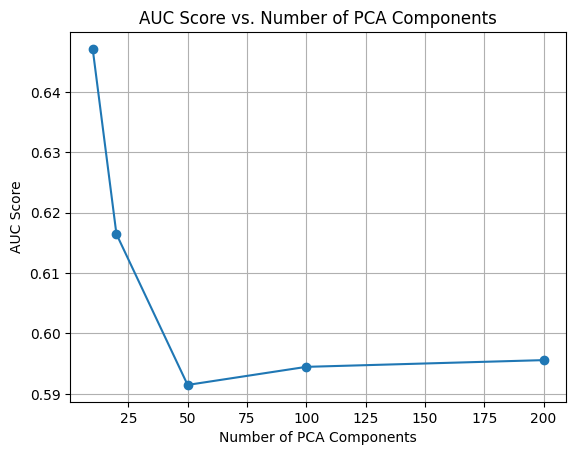

In [23]:
# Plot AUC scores against the number of PCA components
plt.plot(tpot_df["PCA Components"], tpot_df["AUC"], marker="o")
plt.xlabel("Number of PCA Components")
plt.ylabel("AUC Score")
plt.title("AUC Score vs. Number of PCA Components")
plt.grid()
plt.show()